# Resolución de problema de clasificación

## 1. Carga de datos e importación de librerías

In [45]:
"""
Yo sé que después no hace mucha gracia tener importadas 200 clases y funciones que quizás no se usan, 
pero con las prisas del examen prefiero asegurarme que todo está disponible desde el principio (además están ordenadas alfabéticamente... más o menos).
""" 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn import datasets
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, BaggingClassifier, ExtraTreesClassifier, IsolationForest, RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler, Normalizer
from sklearn.preprocessing import QuantileTransformer, KBinsDiscretizer, PolynomialFeatures

from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

#TODO Introducir el dataset con el que se vaya a trabajar
df = pd.read_csv('diamonds.csv')
#! OBTENCIÓN DE UNA MUESTRA SI EL DATASET ES MUY GRANDE
df = df.sample(n=1000, random_state=42)
df.head()



,carat,cut,color,clarity,depth,table,price,x,y,z
1388,0.24,Ideal,G,VVS1,62.1,56.0,559,3.97,4.00,2.47
50052,0.58,Very Good,F,VVS2,60.0,57.0,2201,5.44,5.42,3.26
41645,0.40,Ideal,E,VVS2,62.1,55.0,1238,4.76,4.74,2.95
42377,0.43,Premium,E,VVS2,60.8,57.0,1304,4.92,4.89,2.98
17244,1.55,Ideal,E,SI2,62.3,55.0,6901,7.44,7.37,4.61


## 2. Exploratory data analysis (EDA)

0. Exploracion del dataset (info, describe, shape)
1. Realizar un histplot para tener una noción general.
2. Realizar un gráfico controlando los categóricos, después los exploraremos en mayor porfundida (sns.countplot())
3. Realizar un heatmap para ver correlaciones.
4. Realizar un scatterpolot para explorar las correlaciones vistas.
5. Utiliza boxplot para ver la dispersión de los datos y detectar Outliers.

In [46]:
print('Shape: ', df.shape)
#Obtenemos información sobre el tipo de dato y los nulos por columna
df.info()

Shape:  (1000, 10)
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 1388 to 21429
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    1000 non-null   float64
 1   cut      1000 non-null   object 
 2   color    1000 non-null   object 
 3   clarity  1000 non-null   object 
 4   depth    1000 non-null   float64
 5   table    1000 non-null   float64
 6   price    1000 non-null   int64  
 7   x        1000 non-null   float64
 8   y        1000 non-null   float64
 9   z        1000 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 85.9+ KB


In [47]:
#
#TODO Separamos los categóricos de los numéricos

categorical_features = ['cut', 'color', 'clarity']
numerical_features = ['carat','depth', 'table', 'price', 'x', 'y', 'z']

#TODO Definimos la columna de salida
target = 'price'

### Visualización del dataset 


array([[<Axes: title={'center': 'carat'}>,
        <Axes: title={'center': 'depth'}>,
        <Axes: title={'center': 'table'}>],
       [<Axes: title={'center': 'price'}>, <Axes: title={'center': 'x'}>,
        <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'z'}>, <Axes: >, <Axes: >]], dtype=object)

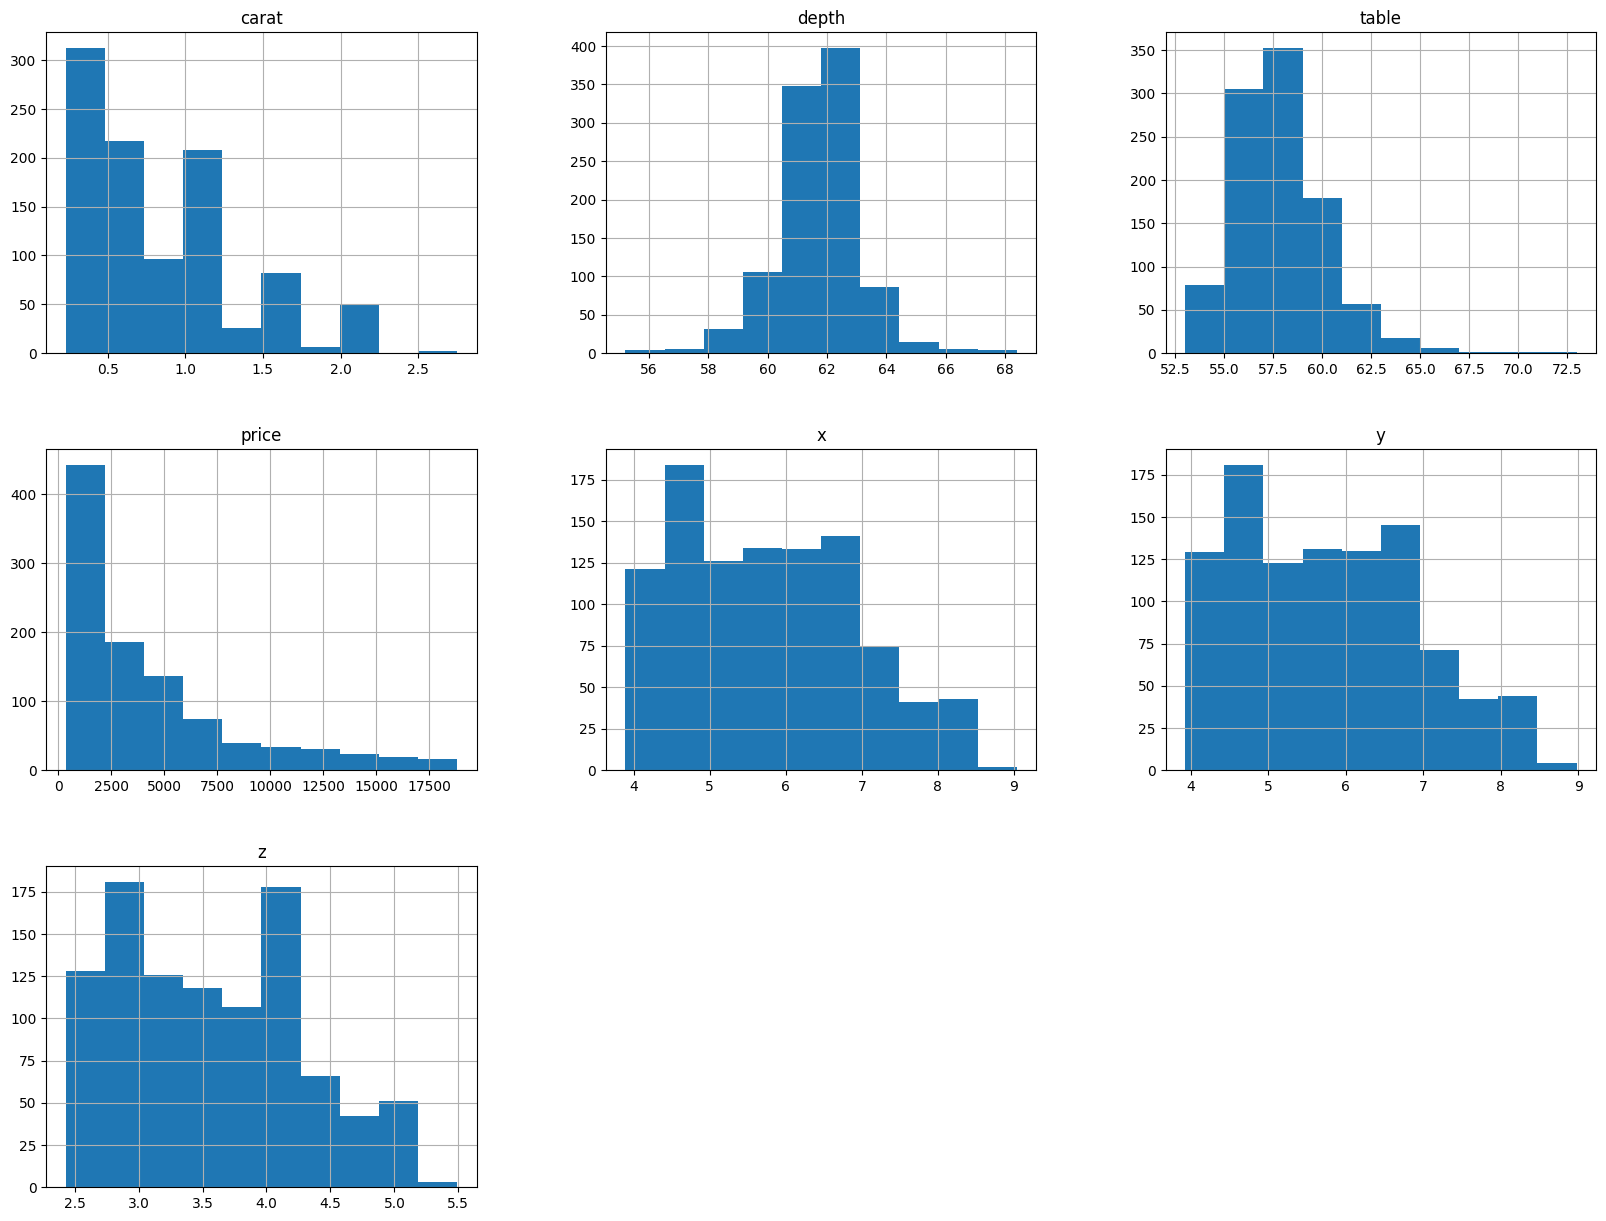

In [48]:
df.hist(bins=10, figsize=(20, 15))

### Exploración de los categóricos

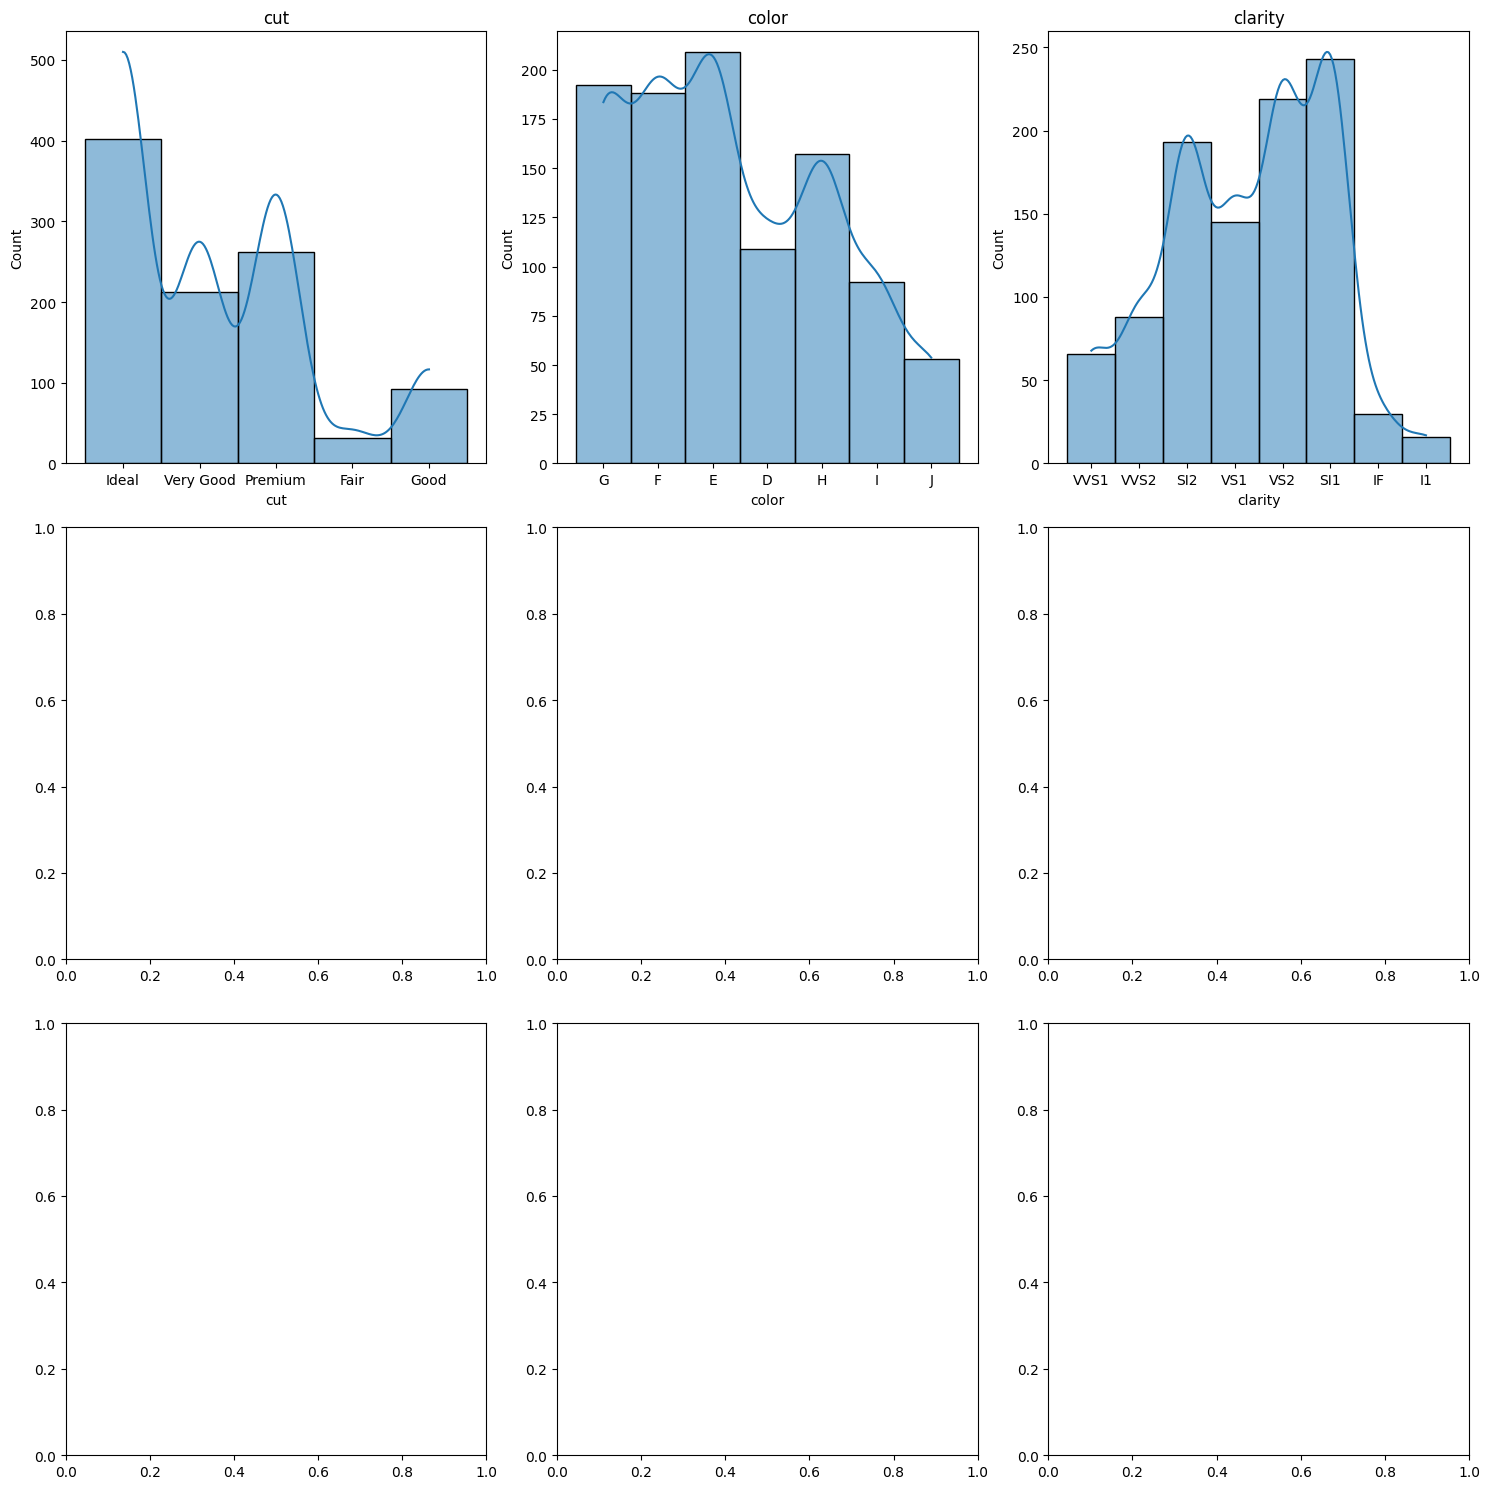

In [9]:

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, feature in enumerate(categorical_features):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    ax.set_title(feature)
    sns.histplot(df[feature], kde=True, ax=ax)

plt.tight_layout()
plt.show()

### Exploración de correlaciones

In [10]:
#
#TODO Codificación de los categóricos para la matriz de correlación


one_hot_encoder = OneHotEncoder(drop='first', sparse_output=True)
encoded_data = one_hot_encoder.fit_transform(df[categorical_features])

encoded_data = encoded_data.toarray()
#Nombres de las columnas
feature_names = one_hot_encoder.get_feature_names_out()

#Creamos un dataframe con los datos codificados
df_encoded = pd.DataFrame(encoded_data, columns=feature_names)
df_encoded



,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
997,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
998,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<Axes: title={'center': 'Matriz de correlación'}>

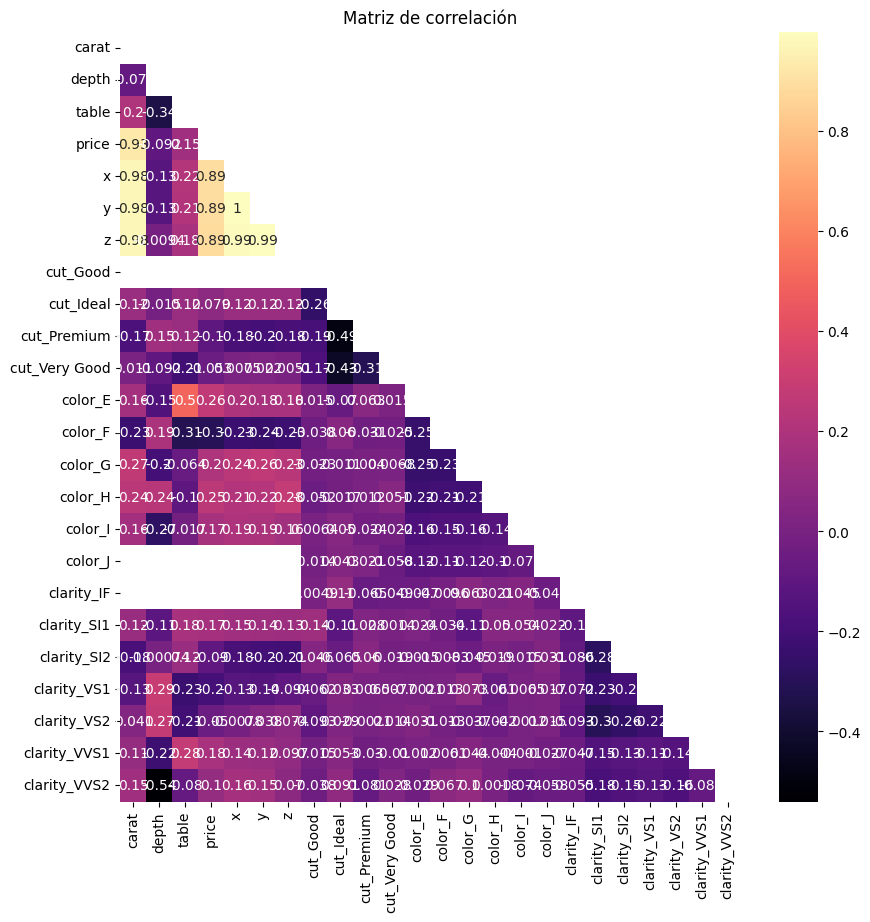

In [11]:
#
#TODO Meter correlaciones con los categóricos

# Concatenar el DataFrame codificado con el DataFrame original
df_combined = pd.concat([df.drop(categorical_features, axis=1), df_encoded], axis=1)

# Calcular la matriz de correlación
df_corr = df_combined.corr()

# Crear una máscara para la mitad superior de la matriz de correlación
mask = np.triu(np.ones_like(df_corr, dtype=bool))

# Dibujar el mapa de calor
plt.figure(figsize=(10, 10))
plt.title('Matriz de correlación')
sns.heatmap(df_corr, mask=mask, annot=True, cmap='magma')


### Scatterplot para profundizar en las correlaciones

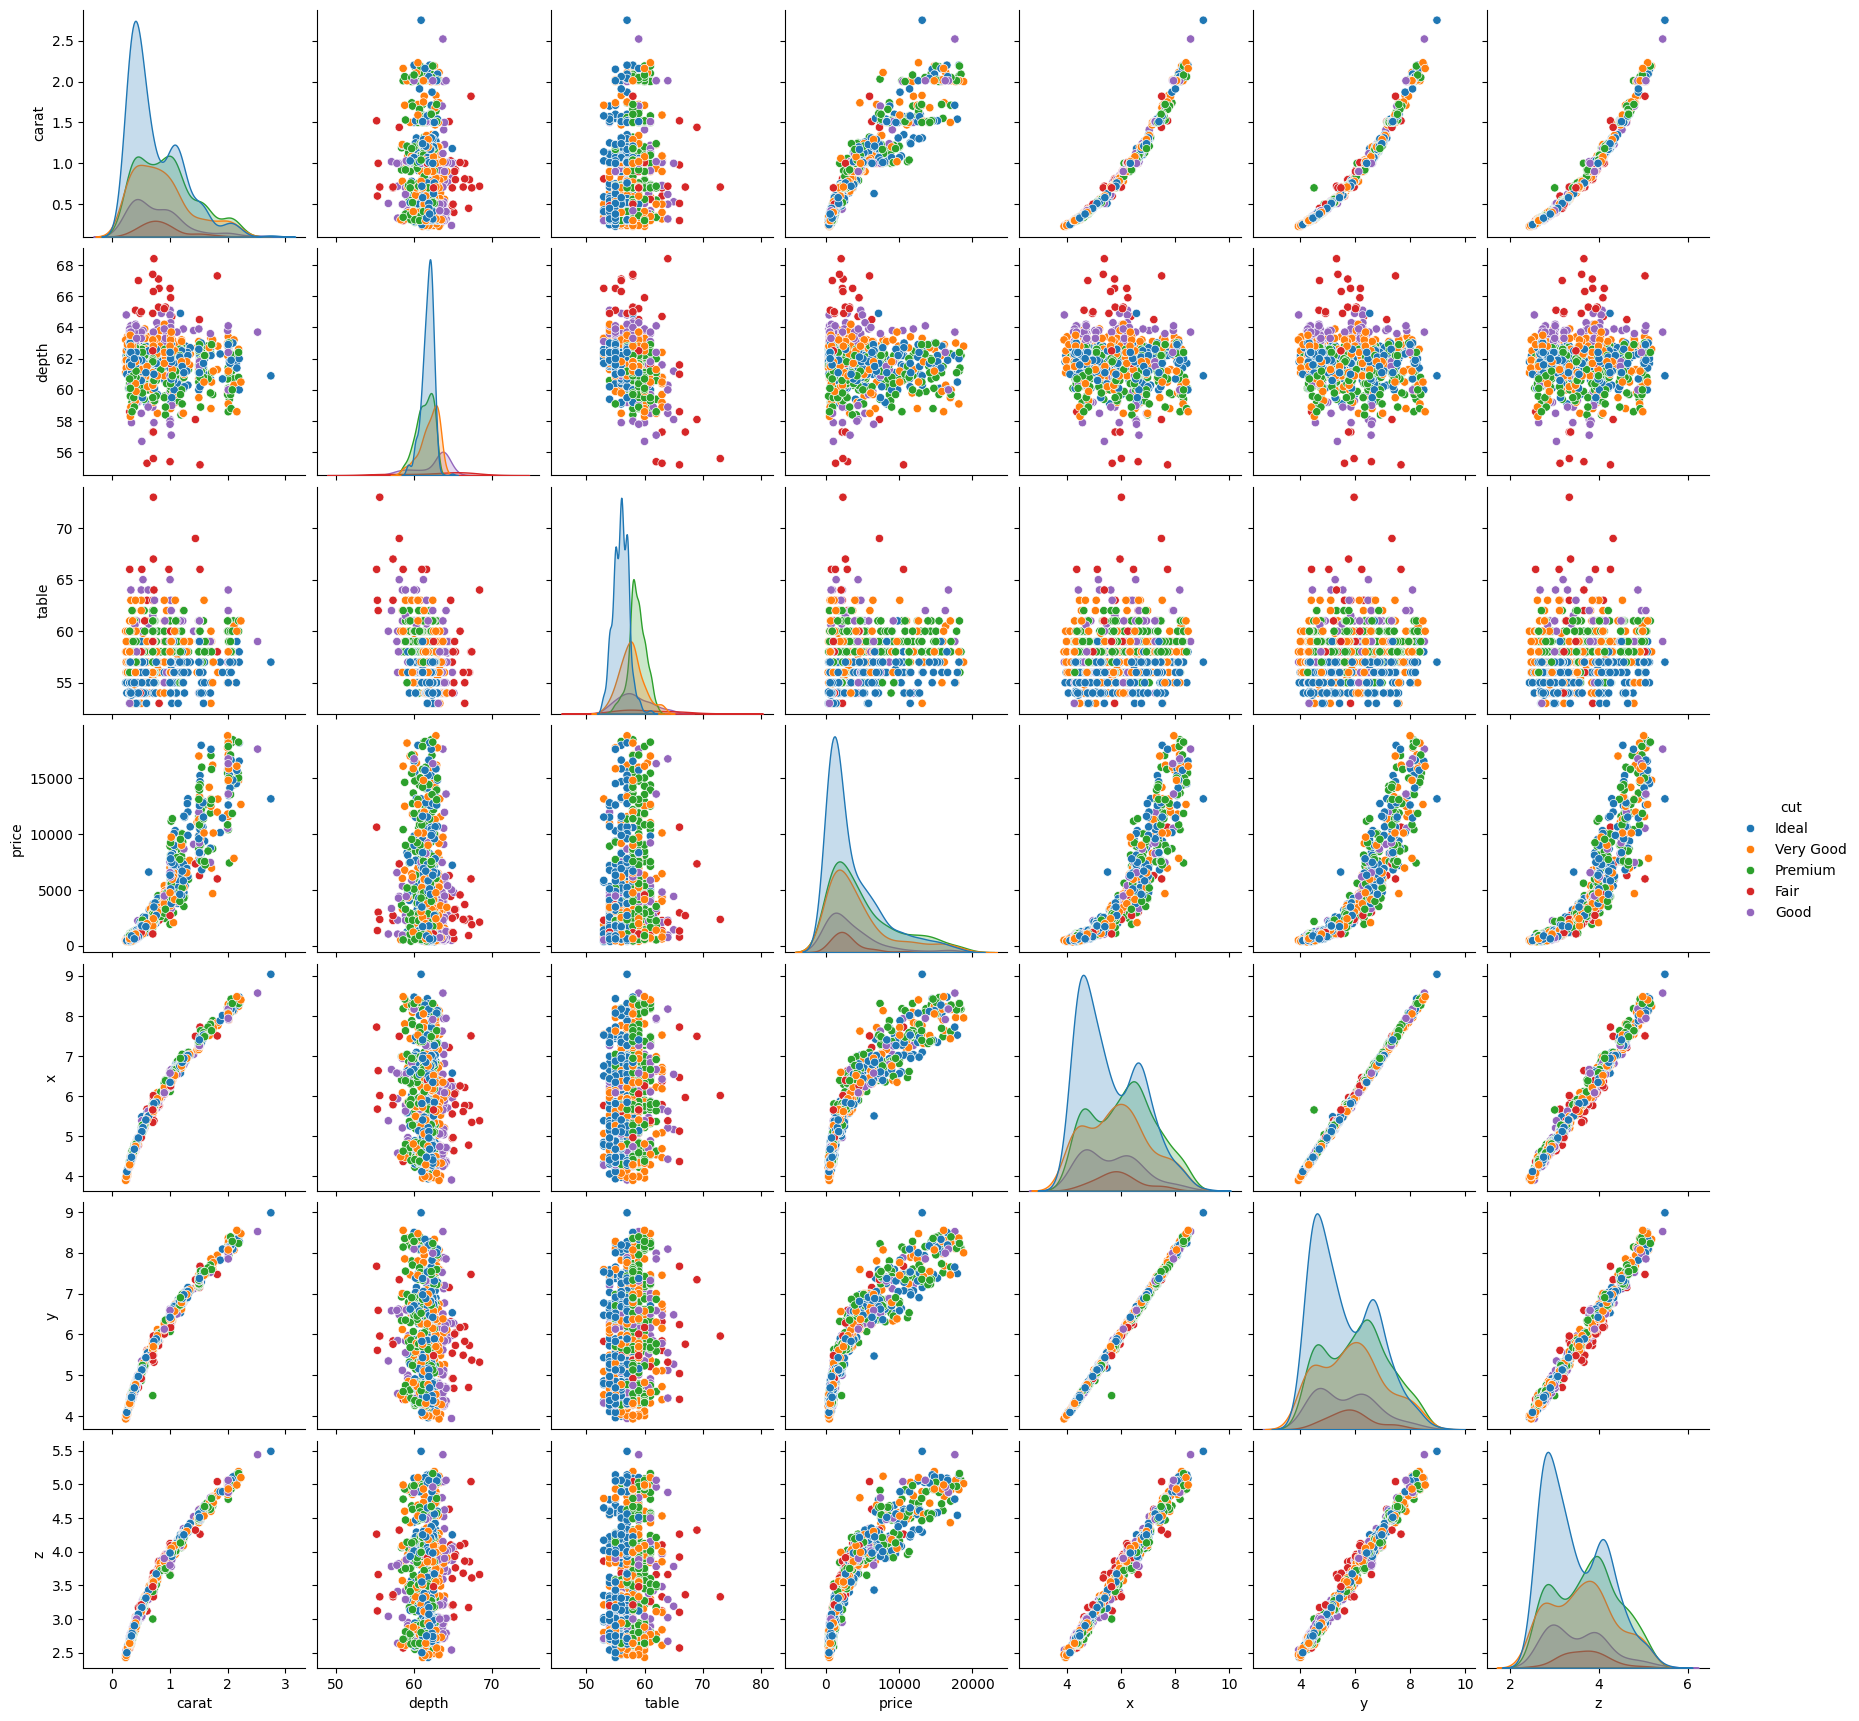

In [13]:
# TODO Introducir el nombre de las columnas que se van a utilizar para predecir, añadir una categórica en hue

# SI NECESITAS VER UNA RELACIÓN MUY CONCRETA UTILIZA ESTE OTRO:
#sns.scatterplot(data=df, x='sepal_length', y='sepal_width', hue='species')

#Para ver todas las relaciones posibles
sns.pairplot(df, hue='cut')

### Boxplot: distribución de datos y detección de Outliers

Text(0.5, 1.0, 'Boxplot para detectar outliers')

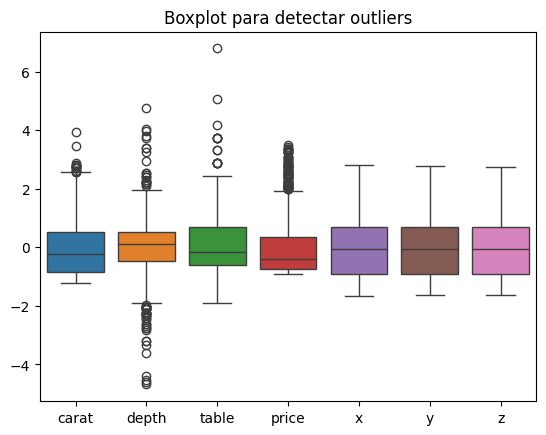

In [49]:
standar_scaler = StandardScaler()
df_scaled = standar_scaler.fit_transform(df[numerical_features])
df_scaled = pd.DataFrame(df_scaled, columns=numerical_features)

#boxplot de una columna con categoría
#sns.boxplot(data=df, x='species', y='sepal_length')

#Boxplot de todas las columnas

sns.boxplot(data=df_scaled)
plt.title('Boxplot para detectar outliers')


In [50]:
df[numerical_features]

,carat,depth,table,price,x,y,z
1388,0.24,62.1,56.0,559,3.97,4.00,2.47
50052,0.58,60.0,57.0,2201,5.44,5.42,3.26
41645,0.40,62.1,55.0,1238,4.76,4.74,2.95
42377,0.43,60.8,57.0,1304,4.92,4.89,2.98
17244,1.55,62.3,55.0,6901,7.44,7.37,4.61
...,...,...,...,...,...,...,...
35207,0.33,61.6,55.0,891,4.47,4.46,2.75
15806,1.00,62.4,55.0,6324,6.34,6.42,3.98
45884,0.58,61.1,56.0,1719,5.40,5.43,3.31
22681,0.38,62.0,55.0,629,4.67,4.69,2.90


## 3. Preparación de las métricas de validación

In [51]:
#
#TODO: Eliminamos provisionalmente los NAN y transformarmos los valores categóricos.
ordinal_encoder  = OrdinalEncoder()
df_dropnan = df.dropna()

X_dropnan = df_dropnan.drop([target], axis=1)
X_dropnan[categorical_features] = ordinal_encoder.fit_transform(X_dropnan[categorical_features])

y_dropnan = df_dropnan[target]


In [52]:
#
#TODO PARA PROBLEMAS DE REGRESIÓN

def calc_predictions(X, y):
    """
    Para obtener las métricas de evaluación, será necesario que tanto la X como la y no contengan valores nulos.
    Además, intenta convertir las columnas categóricas a numéricas.
    """
    df_results = pd.DataFrame(columns=['model_name', 'r2', 'mae', 'mse', 'rmse'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # TODO AJUSTAR EL PESO SI HAY SESGO
    models = [
        LinearRegression(),
        KNeighborsRegressor(weights='distance'),
        DecisionTreeRegressor(),
        RandomForestRegressor(),
        SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1),
        #PoissonRegressor(), Utilizar para conteo de eventos NO-negativos(nº llamadas/hora, nºaccidnetes/tramo)
        
    ]

    for model in models:
        # entrenamiento y predicciones
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # classification metrics
        model_name = model.__class__.__name__
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)

        # guardar resultados
        row = [model_name, r2, mae, mse, rmse]
        df_results.loc[len(df_results)] = row

    return df_results

calc_predictions(X_dropnan, y_dropnan)

,model_name,r2,mae,mse,rmse
0,LinearRegression,0.876235,918.340004,2.273063e+06,1507.667986
1,KNeighborsRegressor,0.873121,903.264423,2.330264e+06,1526.520236
2,DecisionTreeRegressor,0.929507,593.860000,1.294679e+06,1137.839730
3,RandomForestRegressor,0.959046,484.386447,7.521674e+05,867.275865
4,SVR,0.451105,1668.333442,1.008100e+07,3175.059533


## 4. Preprocesado de datos
1. Tratar valores faltantes o nulos.
2. Transformación de categóricos a numéricos (OrdinalEncoder-entrada // LabelEncoder-salida)
3. Tratar Outliers -si procede... muchas veces vamos a necesitarlos.

4. Escalar datos (estandarizar o normalizar)
5. Reducir dimensionalidad del dataset (eliminacion de features SelectKBest)

6. Creación de nuevas features significativas.
7. Discretización de datos -binarizar o kbins.
8. Corregir distribucion de datos y sesgos.

9. Observar si los datos están desbalanceados -demasiadas muestras de uno y pocos de otro.

### Tratar valores faltantes

Comprobamos dónde están los valores faltantes dentro del dataframe. Opcionalmente, podríamos utilizar df.info() si quisiéramos saber cuántos registros tienen valores para cada columna. 

In [53]:
df_copy = df.copy()
df_copy.isnull().sum()


carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [54]:
df_imputed = df.copy()


#TODO Elegir el tipo de IMPUTER que se va a utilizar
simple_imputer = SimpleImputer(strategy='most_frequent')
imputer = KNNImputer()
#imputer = IterativeImputer()

#TODO IMPUTACIÓN DE LOS NUMÉRICOS
# df_imputed_target = pd.DataFrame(df_imputed[target])
# imputer.fit(df_imputed_target)
# df_imputed[target] = imputer.transform(df_imputed_target)
# df_imputed[target] = df_imputed[target].astype('float64')

# df_imputed_col = pd.DataFrame(df_imputed['bill_length_mm'])
# imputer.fit(df_imputed_col)
# df_imputed['bill_length_mm'] = imputer.transform(df_imputed_col)
# df_imputed['bill_length_mm'] = df_imputed['bill_length_mm'].astype('float64')

# df_imputed_col = pd.DataFrame(df_imputed['bill_depth_mm'])
# imputer.fit(df_imputed_col)
# df_imputed['bill_depth_mm'] = imputer.transform(df_imputed_col)
# df_imputed['bill_depth_mm'] = df_imputed['bill_depth_mm'].astype('float64')

# df_imputed_col = pd.DataFrame(df_imputed['flipper_length_mm'])
# imputer.fit(df_imputed_col)
# df_imputed['flipper_length_mm'] = imputer.transform(df_imputed_col)
# df_imputed['flipper_length_mm'] = df_imputed['flipper_length_mm'].astype('float64')

# #TODO IMPUTACIÓN DE LOS CATEGÓRICOS
# df_imputed_col= pd.DataFrame(df_imputed['sex'])
# simple_imputer.fit(df_imputed_col)
# df_imputed['sex'] = simple_imputer.transform(df_imputed_col).flatten()
# df_imputed['sex'] = df_imputed['sex']

df_imputed.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [55]:
#COMPROBACIÓN DE MÉTRICAS DE EVALUACIÓN

X = df_imputed.drop([target], axis=1)
X[categorical_features] = OrdinalEncoder().fit_transform(df_imputed[categorical_features])
y = df_imputed[target]

calc_predictions(X,y)

,model_name,r2,mae,mse,rmse
0,LinearRegression,0.876235,918.340004,2.273063e+06,1507.667986
1,KNeighborsRegressor,0.873121,903.264423,2.330264e+06,1526.520236
2,DecisionTreeRegressor,0.926746,620.792000,1.345387e+06,1159.908338
3,RandomForestRegressor,0.955657,491.214967,8.144108e+05,902.447141
4,SVR,0.451105,1668.333442,1.008100e+07,3175.059533


### Convertir categóricos a numéricos

Puesto que algunos métodos para tratar Outliers son sensibles a los categóricos, vamos a proceder a convertirlos en numéricos ahora. Disponemos de los siguientes métodos:

-get_dummies : método genérico de pandas. Sobredimensiona el df con demasiadas columnas. No recomendable.

-LabelEncoder : clase de ScikitLearn para datos de salida.

-OrdinalEncoder: clase de scikitLearn para datos de entrada.

-OneHotEncoder : crear columnas con 0 y 1 para indicar si la categoría es o no. Puede sobredimensionar el dataset... así que de momento no vamos a utilizarlo mucho.

In [56]:
#Utilizaremos el ordinal encoder para transformar la columna categórica a numérica en la X

ordinal_encoder = OrdinalEncoder()

df_2 = df_imputed.copy()
df_2[categorical_features] = ordinal_encoder.fit_transform(df_2[categorical_features])

X = df_2.drop(target, axis=1) 
y = df_2[target] 

calc_predictions(X,y)

,model_name,r2,mae,mse,rmse
0,LinearRegression,0.876235,918.340004,2.273063e+06,1507.667986
1,KNeighborsRegressor,0.873121,903.264423,2.330264e+06,1526.520236
2,DecisionTreeRegressor,0.925992,633.584000,1.359230e+06,1165.860396
3,RandomForestRegressor,0.955949,498.347907,8.090471e+05,899.470482
4,SVR,0.451105,1668.333442,1.008100e+07,3175.059533


### Identificar outliers y tratarlos (si procede)
CONSIDERACIONES:
1. El IQR es para datos univariantes. Si vas a trabajar con varias columnas, usa el Isolation Forest.
2. El isolation Forest no se lleva bien con los categóricos. Asegúrate de quitarlos de este paso.
3. El Isolation Forest no trabaja con NaN ni valores faltantes. Hay que manejarlos antes de ajustar el modelo.

In [22]:
# Configurar Isolation Forest (la contaminación es la proporción de outliers esperados)
iso = IsolationForest(contamination=0.01)  

df_3 = df_2.copy()

# Elimina las columnas no relevantes para la detección de outliers.. por ejemplo los categóricos (aunque ahora sean numéricos)
df_3 = df_3.drop(columns=categorical_features)

# Ajusta el modelo y predecir outliers
outliers = iso.fit_predict(df_3)

# Agregar resultados de outliers como una columna en el DataFrame original
df_2['outlier'] = outliers

# Filtrar outliers
df_3 = df_2[df_2['outlier'] == 1].copy()

# Eliminar la columna 'outlier' del DataFrame df_sin_outliers si no es necesaria
df_3.drop(columns=['outlier'], inplace=True)

# Verificar el tamaño de los DataFrames para asegurarse de que los outliers se eliminaron correctamente
print("Tamaño del df_2:", df_2.shape)
print("Tamaño del df_3 sin outliers:", df_3.shape)


X_3 = df_3.drop([target], axis=1)
y_3 = df_3[target] 

#TODO: EN CASO DE EMPEORAR LAS MÉTRICAS DE EVALUACIÓN, MANTENER LOS OUTLIERS
calc_predictions(X_3,y_3)

Tamaño del df_2: (1000, 11)
Tamaño del df_3 sin outliers: (990, 10)


,model_name,r2,mae,mse,rmse
0,LinearRegression,0.907094,889.485055,1.595641e+06,1263.186659
1,KNeighborsRegressor,0.898763,791.831425,1.738724e+06,1318.606819
2,DecisionTreeRegressor,0.902988,675.858871,1.666166e+06,1290.800628
3,RandomForestRegressor,0.956322,482.805820,7.501524e+05,866.113385
4,SVR,0.461445,1543.130874,9.249555e+06,3041.308163


### Escalar datos 
Utiliza MinMaxScaler si necesitas que todo esté entre 0-1 y no te importan los Outliers.
Utiliza StandarScaler si quieres desviación estándar de 1 y 0 de media, y SÍ te importan los Outliers.

Text(0.5, 1.0, 'Boxplot para detectar outliers / datos escalados')

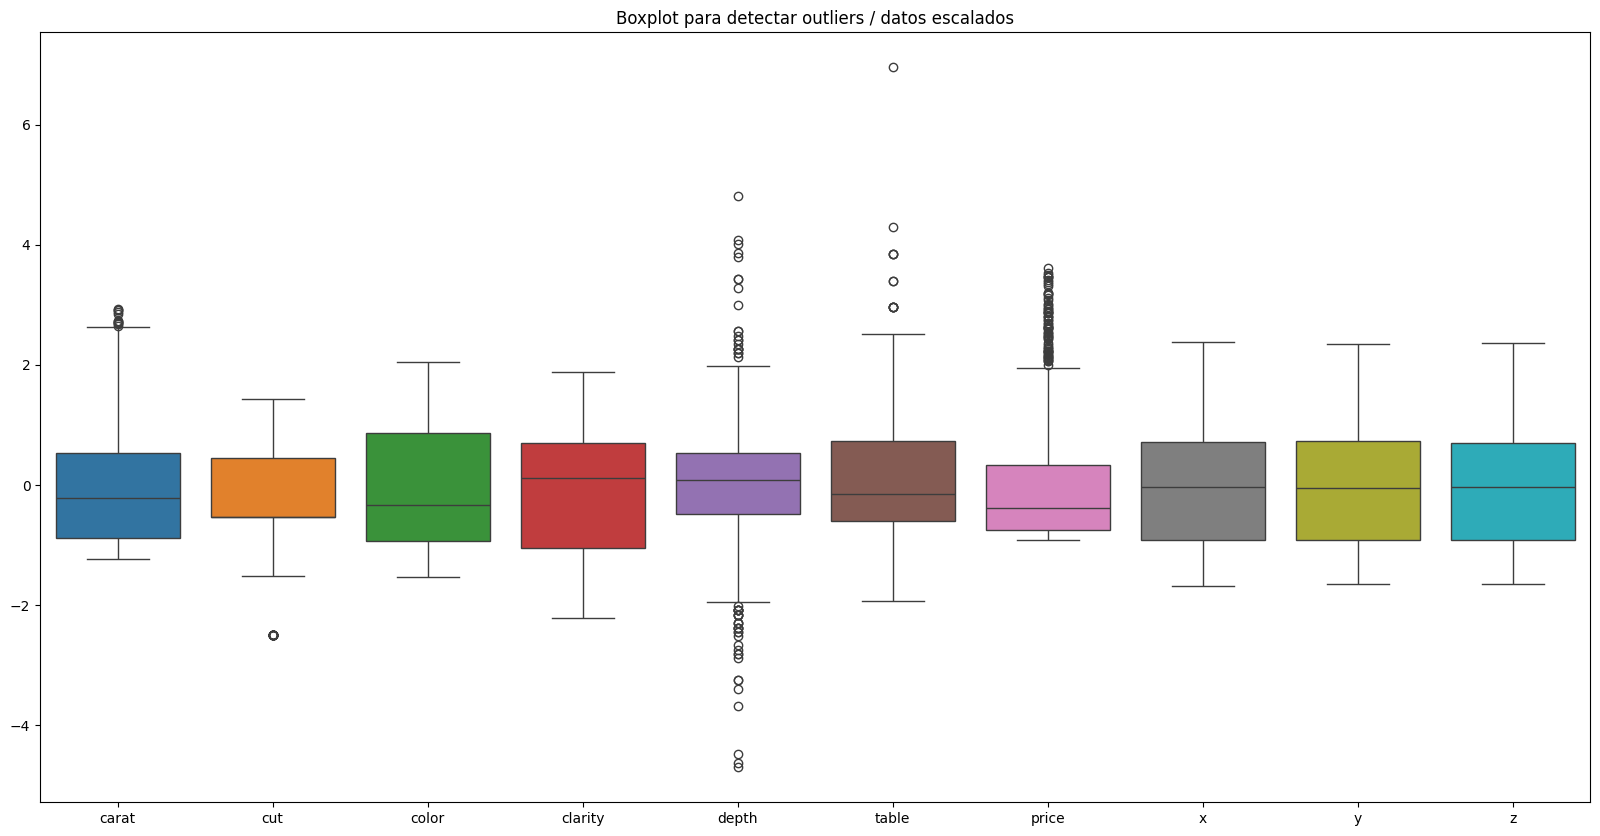

In [23]:

df_3_scaled = pd.DataFrame(standar_scaler.fit_transform(df_3), columns=df_3.columns)

plt.figure(figsize=(20, 10))
sns.boxplot(data=df_3_scaled)
plt.title('Boxplot para detectar outliers / datos escalados')

In [24]:
#
#! PARA EVITAR CONFLICTO, seguiremos haciendo las pruebas con la X y la y original, DONDE SE MANTIENEN LOS OUTLIERS

#TODO Elige de qué manera quieres escalar los datos
scaler = StandardScaler()
#scaler = MinMaxScaler()

#Escalamos todo menos los categóricos
X_estandar = scaler.fit_transform(df_2.drop(categorical_features, axis=1))

#Añadimos la columna categórica
X_estandar = pd.concat([df_2, df_2[categorical_features]], axis=1)

#Comprobamos que se ha escalado correctamente
print(X_estandar.head())

calc_predictions(X_estandar, y)



       carat  cut  color  clarity  depth  table  price     x     y     z  \
1388    0.24  2.0    3.0      6.0   62.1   56.0    559  3.97  4.00  2.47   
50052   0.58  4.0    2.0      7.0   60.0   57.0   2201  5.44  5.42  3.26   
41645   0.40  2.0    1.0      7.0   62.1   55.0   1238  4.76  4.74  2.95   
42377   0.43  3.0    1.0      7.0   60.8   57.0   1304  4.92  4.89  2.98   
17244   1.55  2.0    1.0      3.0   62.3   55.0   6901  7.44  7.37  4.61   

       outlier  cut  color  clarity  
1388         1  2.0    3.0      6.0  
50052        1  4.0    2.0      7.0  
41645        1  2.0    1.0      7.0  
42377        1  3.0    1.0      7.0  
17244        1  2.0    1.0      3.0  


,model_name,r2,mae,mse,rmse
0,LinearRegression,1.000000,2.508841e-12,8.938927e-24,2.989804e-12
1,KNeighborsRegressor,0.999973,9.326445e+00,4.931545e+02,2.220708e+01
2,DecisionTreeRegressor,0.999651,2.952800e+01,6.417280e+03,8.010793e+01
3,RandomForestRegressor,0.999916,1.652600e+01,1.535131e+03,3.918075e+01
4,SVR,-0.154471,3.063627e+03,2.120301e+07,4.604673e+03


### Eliminacion de features poco relevantes

Utilizaremos SelectKBest -sabiendo que podemos utilizar árboles de decisión o RFE. 
Con SelectKBest hay distintos métodos dependiendo de si son datos continuos, categóricos, numéricos... Por defecto el sistema es ANOVA, que se basa en la varianza.

In [25]:
df_2.describe()

,carat,cut,color,clarity,depth,table,price,x,y,z,outlier
count,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000
mean,0.827500,2.534000,2.56700,3.78200,61.759700,57.368800,4165.147000,5.80121,5.800870,3.580360,0.980000
std,0.490193,1.022688,1.67998,1.70921,1.401489,2.303578,4190.104476,1.14740,1.142003,0.700021,0.199097
min,0.230000,0.000000,0.00000,0.00000,55.200000,53.000000,360.000000,3.89000,3.930000,2.430000,-1.000000
25%,0.410000,2.000000,1.00000,2.00000,61.100000,56.000000,1007.000000,4.74000,4.750000,2.950000,1.000000
50%,0.710000,2.000000,2.00000,4.00000,61.900000,57.000000,2542.500000,5.74500,5.750000,3.550000,1.000000
75%,1.080000,3.000000,4.00000,5.00000,62.500000,59.000000,5569.750000,6.60000,6.600000,4.060000,1.000000
max,2.750000,4.000000,6.00000,7.00000,68.400000,73.000000,18803.000000,9.04000,8.980000,5.490000,1.000000


In [26]:
df_selectkbest = df_2.drop([target, 'outlier'], axis=1).columns

# Seleccionar las K mejores características utilizando ANOVA F-value (por defecto)
selector = SelectKBest(k=3)
X_selectkbest = selector.fit_transform(X, y)


# Obtener los nombres de las características seleccionadas
mask = selector.get_support() 
selected_features = df_selectkbest[mask] 
print("Selected features:", selected_features)


calc_predictions(X_selectkbest, y)


Selected features: Index(['carat', 'y', 'z'], dtype='object')


,model_name,r2,mae,mse,rmse
0,LinearRegression,0.837026,1014.406051,2.993181e+06,1730.081199
1,KNeighborsRegressor,0.850630,962.387381,2.743335e+06,1656.301661
2,DecisionTreeRegressor,0.749677,1210.038000,4.597438e+06,2144.163785
3,RandomForestRegressor,0.864158,926.522793,2.494882e+06,1579.519431
4,SVR,0.739094,1164.512394,4.791791e+06,2189.015982


### Creación de nuevas features - PCA

In [27]:

# Aplicar PCA
pca = PCA(n_components=2)  # Queremos reducir a 2 componentes principales
X_pca = pca.fit_transform(X)

# CREAR UN DATAFRAME CON LOS COMPONENTES PRINCIPALES
df_pca = pd.DataFrame(data=X_pca, columns=['componente_1', 'componente_2'])
df_pca[target] = y
 
print(df_pca.head())

calc_predictions(X_pca, y)


   componente_1  componente_2  price
0     -2.725105     -1.823893    NaN
1     -0.684374     -2.164268    NaN
2     -3.584959     -2.103843    NaN
3     -1.419671     -3.022666    NaN
4     -1.254102      2.205546    NaN


,model_name,r2,mae,mse,rmse
0,LinearRegression,0.413257,2415.666824,1.077612e+07,3282.699508
1,KNeighborsRegressor,0.340092,2297.169883,1.211987e+07,3481.359994
2,DecisionTreeRegressor,-0.042025,2916.440000,1.913782e+07,4374.679106
3,RandomForestRegressor,0.362437,2278.147867,1.170947e+07,3421.910542
4,SVR,0.291770,2230.805795,1.300735e+07,3606.570115


### Distribución de los datos - QuantileTransform

En caso de que queramos que los datos sigan una distribución normal, aplicaremos el QuantileTransform.

              model_name        r2       mae       mse      rmse
0       LinearRegression  0.853446  0.250670  0.158698  0.398369
1    KNeighborsRegressor  0.877395  0.261647  0.132765  0.364369
2  DecisionTreeRegressor  0.878233  0.216076  0.131857  0.363121
3  RandomForestRegressor  0.948013  0.158061  0.056295  0.237266
4                    SVR  0.807681  0.259830  0.208256  0.456350


<Axes: xlabel='price', ylabel='Count'>

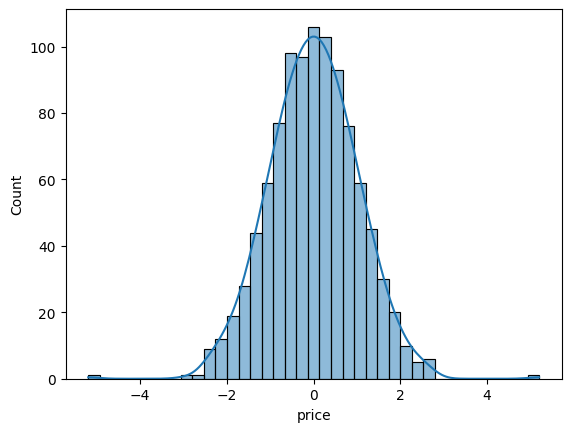

In [28]:

transformer = QuantileTransformer(output_distribution='normal', n_quantiles=100, random_state=0)

# Ajustar y transformar los datos
df_transformed = transformer.fit_transform(df_2)

# Convertir de nuevo a DataFrame para facilitar la visualización
df_transformed = pd.DataFrame(df_transformed, columns=df_2.columns)

X_trans = df_transformed.drop(target, axis=1)
y_trans = df_transformed[target]

print(calc_predictions(X_trans,y_trans))
sns.histplot(df_transformed[target], kde=True)


### Discretización de datos - KbinsDiscretizer

Para realizar este paso será necesario conocer bien nuestro dataset y ver qué datos podemos discretizar, si es que hay algún rango que nos interese crear. 

In [36]:
#
#TODO NO ELIJAS EL TARGET, ELIGE OTRA CARACTERÍSTICA DIFERENTE Y QUE SEA RELEVANTE

column_to_discretize= 'depth'
X

,carat,cut,color,clarity,depth,table,x,y,z
1388,0.24,2.0,3.0,6.0,62.1,56.0,3.97,4.00,2.47
50052,0.58,4.0,2.0,7.0,60.0,57.0,5.44,5.42,3.26
41645,0.40,2.0,1.0,7.0,62.1,55.0,4.76,4.74,2.95
42377,0.43,3.0,1.0,7.0,60.8,57.0,4.92,4.89,2.98
17244,1.55,2.0,1.0,3.0,62.3,55.0,7.44,7.37,4.61
...,...,...,...,...,...,...,...,...,...
35207,0.33,2.0,5.0,1.0,61.6,55.0,4.47,4.46,2.75
15806,1.00,2.0,1.0,2.0,62.4,55.0,6.34,6.42,3.98
45884,0.58,2.0,3.0,5.0,61.1,56.0,5.40,5.43,3.31
22681,0.38,2.0,6.0,7.0,62.0,55.0,4.67,4.69,2.90


              model_name        r2          mae           mse         rmse
0       LinearRegression  0.876235   918.340004  2.273063e+06  1507.667986
1    KNeighborsRegressor  0.873121   903.264423  2.330264e+06  1526.520236
2  DecisionTreeRegressor  0.922256   639.388000  1.427850e+06  1194.926878
3  RandomForestRegressor  0.955763   496.675327  8.124546e+05   901.362621
4                    SVR  0.451105  1668.333442  1.008100e+07  3175.059533


<Axes: xlabel='depth', ylabel='Count'>

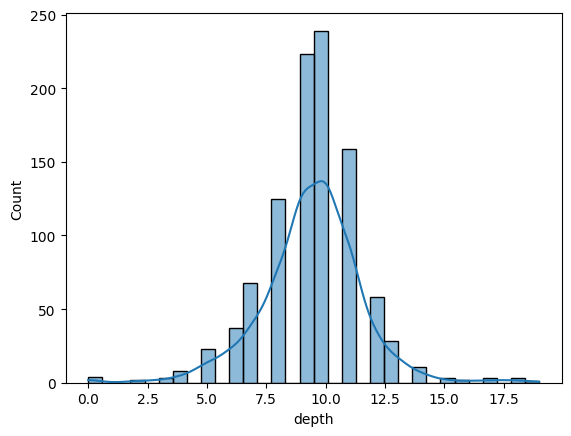

In [37]:
# Crear el discretizador
discretizer = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='uniform')

X_disc = X.copy()

#Modificamos los valores de la columna que queramos discretizar
X_disc[column_to_discretize] = discretizer.fit_transform(X_disc[[column_to_discretize]])

print(calc_predictions(X,y))

#Visualizamos la columna discretizada
sns.histplot(X_disc[column_to_discretize], kde=True)


# Modelado y entrenamiento del modelo

En esta fase procedemos directamente a entrenar el modelo teniendo en cuenta los pasos más convenientes. Para ello, utilizaremos un Pipeline de CLASIFICACIÓN.

### 1. Creación de Pipeline de CLASIFICACIÓN

In [57]:
#
#TODO Imprime los categóricos y numéricos, y encárgate de SACAR el TARGET (copiar y pegar el array)
numerical_features = [feature for feature in numerical_features if feature != target]

print('NUMÉRICOS: ', numerical_features)
print('CATEGÓRICOS: ', categorical_features)

NUMÉRICOS:  ['carat', 'depth', 'table', 'x', 'y', 'z']
CATEGÓRICOS:  ['cut', 'color', 'clarity']


In [58]:
#
#TODO Adapta esta parte y asegúrate de que la 'y' tiene todos los valores
#y.isnull().sum()
X = df_copy.drop(target, axis=1)
y = df_copy[target]
y = imputer.fit_transform(y.values.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# TODO Aplicar IsolationForest e IQR antes de empezar con el pipeline (si es necesario)
# TODO Aplicar LabelEncoder a la columna categórica
# TODO Aplicar discretizer a la columna que se quiera discretizar antes del pipeline


# Crear el pipeline de preprocesamiento para numéricos
pipeline_num = Pipeline([
    ('imputer_iterative', IterativeImputer()),
    ('scaler', StandardScaler()),
    ('select_kbest', SelectKBest(k=3)),
    ('pca', PCA(n_components=2)),
    ('quantile_transformer', QuantileTransformer(output_distribution='normal', n_quantiles=100, random_state=0))
])

# columnas categoricas
pipeline_cat = Pipeline([
    ("imputer_constant", SimpleImputer(strategy='most_frequent')),
     ("encoder", OrdinalEncoder()),
    
])

preprocessor = ColumnTransformer([
    ("numeric", pipeline_num, numerical_features ),
    ("categorical", pipeline_cat, categorical_features)
])
preprocessor.fit(X_train, y_train)

c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer_iterative',
                                                  IterativeImputer()),
                                                 ('scaler', StandardScaler()),
                                                 ('select_kbest',
                                                  SelectKBest(k=3)),
                                                 ('pca', PCA(n_components=2)),
                                                 ('quantile_transformer',
                                                  QuantileTransformer(n_quantiles=100,
                                                                      output_distribution='normal',
                                                                      random_state=0))]),
                                 ['carat', 'depth', 'table', 'x', 'y', 'z']),
                                ('categorical',
                                 Pipeline(steps=[('imputer_constant',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder())]),
                                 ['cut', 'color', 'clarity'])])

### 2. Métricas de evaluación para el Pipeline de Clasificación

In [59]:
def calc_predictions_pipeline(model, X_train, y_train, X_test, y_test):
    # Crear un DataFrame para almacenar los resultados
    df_results = pd.DataFrame(columns=['model_name', 'mse', 'mse_squared', 'r2', 'mae'])
  
    # Entrenar el modelo
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calcular las métricas de regresión
    model_name = model.__class__.__name__
    mse = mean_squared_error(y_test, y_pred)
    mse_squared = mse ** 2
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    # Guardar los resultados en el DataFrame
    row = [model_name, mse, mse_squared, r2, mae]
    df_results.loc[len(df_results)] = row
    
    return df_results

### 3. Evaluamos las métricas de nuestro pipeline

In [60]:
# Transformar los datos de entrenamiento y de prueba
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

df_evaluation = pd.DataFrame(columns=['model_name', 'mse', 'mse_squared', 'r2', 'mae'])


#TODO ELEGIR LOS MODELOS QUE SE VAYAN A USAR Y CONCATENARLOS AL FINAL DEL TODO

# Modelo 1: KNeighborsClassifier
knn_model = KNeighborsRegressor()
knn_model.fit(X_train_preprocessed, y_train)
y_knn_pred = knn_model.predict(X_test_preprocessed)
knn_eval = calc_predictions_pipeline(knn_model, X_train_preprocessed, y_train, X_test_preprocessed, y_test)

# Modelo 2: RandomForestClassifier
rf_model = RandomForestRegressor()
rf_model.fit(X_train_preprocessed, y_train)
y_rf_pred = pd.DataFrame(rf_model.predict(X_test_preprocessed))
rf_eval = calc_predictions_pipeline(rf_model, X_train_preprocessed, y_train, X_test_preprocessed, y_test)

# Modelo 3: SVR
svr_model = SVR()
svr_model.fit(X_train_preprocessed, y_train)
y_svr_pred = pd.DataFrame(svr_model.predict(X_test_preprocessed))
svr_eval = calc_predictions_pipeline(svr_model, X_train_preprocessed, y_train, X_test_preprocessed, y_test)



# Modelo 4: Polynomial Regression 
#! RECOMENDADO PARA UNA SOLA FEATURE, NO PARA VARIAS
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train_preprocessed)
X_test_poly = poly.transform(X_test_preprocessed)

lr_model = LinearRegression()
lr_model.fit(X_train_poly, y_train)
y_lr_pred = pd.DataFrame(lr_model.predict(X_test_poly))

lr_eval = calc_predictions_pipeline(lr_model, X_train_poly, y_train, X_test_poly, y_test)


df_evaluation = pd.concat([df_evaluation, knn_eval, rf_eval, svr_eval, lr_eval], axis=0)

df_evaluation

c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Administrador.CRISASUSESTUD

,model_name,mse,mse_squared,r2,mae
0,KNeighborsRegressor,2.289651e+06,5.242504e+12,0.873841,894.141000
0,RandomForestRegressor,8.053394e+05,6.485716e+11,0.955626,490.593642
0,SVR,2.106671e+07,4.438065e+14,-0.160765,3030.111568
0,LinearRegression,1.697868e+06,2.882756e+12,0.906448,833.199580


### 4. Dibujamos los residuos de cada modelo

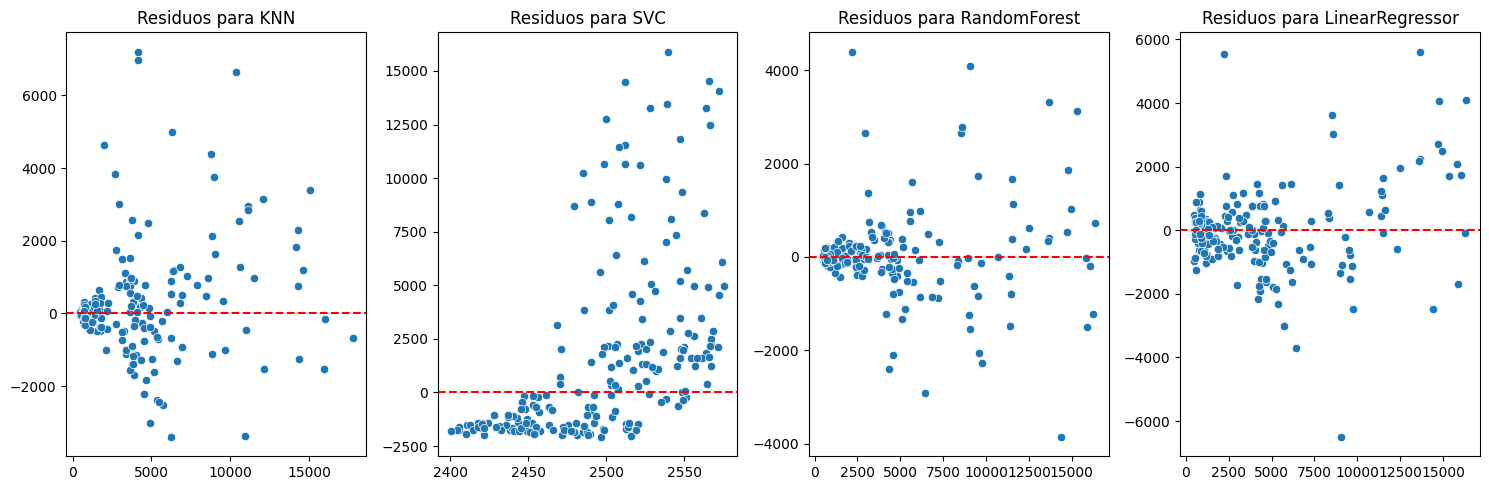

In [61]:
# Definición de la gráfica (1 fila x 3 cols)
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

#Residuo para el KNN
residuos = y_test - y_knn_pred 
sns.scatterplot(x= y_knn_pred[:,0], y = residuos[:,0], ax=axs[0])
axs[0].set_title('Residuos para KNN')
axs[0].axhline(y=0, color='r', linestyle='--')

#Residuo para el SVC
residuos_svc = np.ravel(y_test) - np.ravel(y_svr_pred)
sns.scatterplot(x=np.ravel(y_svr_pred), y=residuos_svc, ax=axs[1])
axs[1].axhline(y=0, color='r', linestyle='--')
axs[1].set_title('Residuos para SVC')

#Residuo para el RandomForest
residuos_rf = y_test - y_rf_pred
sns.scatterplot(x=np.ravel(y_rf_pred), y=np.ravel(residuos_rf), ax=axs[2])
axs[2].set_title('Residuos para RandomForest')
axs[2].axhline(y=0, color='r', linestyle='--')

#Residuo para el LinearRegressor
residuos_lr = y_test - y_lr_pred
sns.scatterplot(x=np.ravel(y_rf_pred), y=np.ravel(residuos_lr), ax=axs[3])
axs[3].set_title('Residuos para LinearRegressor')
axs[3].axhline(y=0, color='r', linestyle='--')

plt.tight_layout()


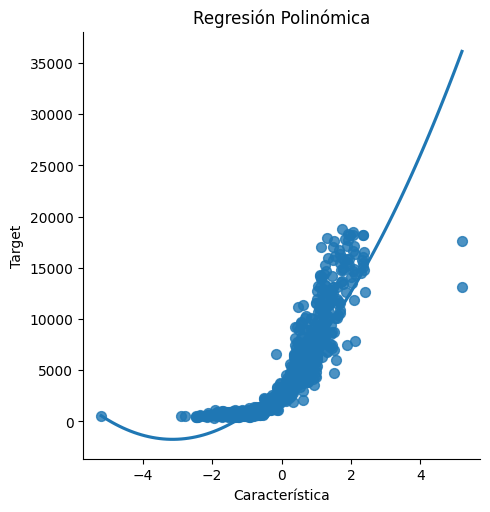

In [62]:

# Seleccionar solo una característica para la visualización
feature_index = 0  # Cambia esto para elegir otra característica
X_train_single_feature = X_train_preprocessed[:, feature_index]
X_test_single_feature = X_test_preprocessed[:, feature_index]

# Combinar los datos de entrenamiento y prueba para la visualización
X_single_feature = np.concatenate([X_train_single_feature, X_test_single_feature])
y = np.concatenate([y_train, y_test])

# Asegurarse de que las características son unidimensionales
X_single_feature = X_single_feature.flatten()
y = y.flatten()

# Crear un DataFrame para seaborn
df = pd.DataFrame({
    'Feature': X_single_feature,
    'Target': y
})

# Visualizar la regresión polinómica utilizando seaborn.lmplot
sns.lmplot(x='Feature', y='Target', data=df, order=2, ci=None, scatter_kws={"s": 50})

plt.xlabel('Característica')
plt.ylabel('Target')
plt.title('Regresión Polinómica')
plt.show()


## Keras y clasificación multiclase

Para utilizar una red neuronal, sigue los siguientes pasos:
1. Crea el modelo con Keras usando su arquitectura.
2. Compila el modelo -model.compile.
3. Entreanmiento -model.fit
4. Observa lo que haya salido del modelo: model.sumary()
5. Pintar el error -sns.lineplot()
6. Evaluación del modelo
7. Realiza predicciones.

In [63]:
kr = tf.keras

kr.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(42)

# 1 Crear el modelo
keras_model = kr.Sequential([
    kr.layers.Dense(10, activation='relu'),
    kr.layers.Dense(5, activation='relu'),
    kr.layers.Dense(5, activation='relu'),
    kr.layers.Dense(5, activation='relu'),
    kr.layers.Dense(1) #!Para regresión, la última capa una sola neurona y por defecto nada, que es lineal
])

# 2 Compile para terminar la configuración
keras_model.compile(optimizer=kr.optimizers.RMSprop(),
              loss='mse',
              metrics=[kr.metrics.RootMeanSquaredError(),
                       kr.metrics.MeanAbsoluteError(),
                       kr.metrics.MeanSquaredError()])

# 3 entrenamiento
keras_model.fit(X_train_preprocessed, y_train, epochs=50)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 33916140.0000 - mean_absolute_error: 4107.6787 - mean_squared_error: 33916140.0000 - root_mean_squared_error: 5820.1055
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33911464.0000 - mean_absolute_error: 4107.1455 - mean_squared_error: 33911464.0000 - root_mean_squared_error: 5819.7041 
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33904860.0000 - mean_absolute_error: 4106.3999 - mean_squared_error: 33904860.0000 - root_mean_squared_error: 5819.1372 
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33895504.0000 - mean_absolute_error: 4105.3457 - mean_squared_error: 33895504.0000 - root_mean_squared_error: 5818.3340 
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33882332.0000 - mean_absolute_error: 4103.8721 - mean_squared_error: 33882332.0000 - root_mean_squared_error: 5817.2031 
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33863620.0000 - mean_absolute_error: 4101.7822 

## Evaluación

In [29]:
%pip install graphviz, pydot

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: 'graphviz,'

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [64]:
kr.utils.plot_model(keras_model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [65]:
keras_model.history.history

{'loss': [34516476.0,
  34511496.0,
  34504328.0,
  34494204.0,
  34479756.0,
  34459436.0,
  34432900.0,
  34399436.0,
  34357720.0,
  34304300.0,
  34237368.0,
  34154556.0,
  34053332.0,
  33930948.0,
  33784368.0,
  33610332.0,
  33405542.0,
  33166536.0,
  32889652.0,
  32571226.0,
  32207670.0,
  31795404.0,
  31331064.0,
  30811566.0,
  30234324.0,
  29597274.0,
  28899118.0,
  28139584.0,
  27319590.0,
  26441538.0,
  25509620.0,
  24530150.0,
  23511888.0,
  22466442.0,
  21408568.0,
  20356500.0,
  19332130.0,
  18360934.0,
  17471302.0,
  16692704.0,
  16051263.0,
  15561093.0,
  15213724.0,
  14977457.0,
  14811209.0,
  14681119.0,
  14567067.0,
  14459418.0,
  14353976.0,
  14248948.0],
 'mean_absolute_error': [4139.146484375,
  4138.57568359375,
  4137.76318359375,
  4136.62109375,
  4135.01171875,
  4132.75634765625,
  4129.79052734375,
  4126.0439453125,
  4121.38427734375,
  4115.42919921875,
  4107.958984375,
  4098.7119140625,
  4087.394287109375,
  4073.6845703125,


<Axes: >

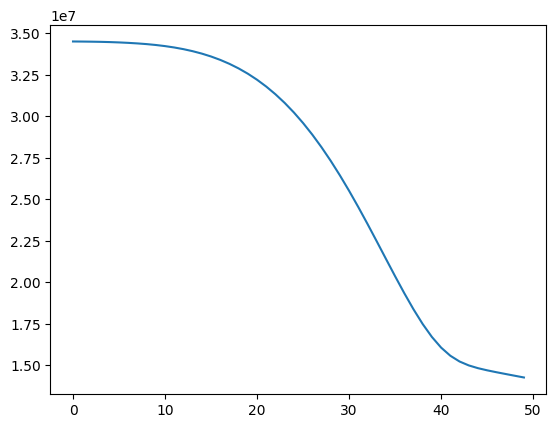

In [66]:
mse = keras_model.history.history['loss']
sns.lineplot(x=range(len(mse)), y=mse)

In [67]:
training_score = keras_model.evaluate(X_train_preprocessed, y_train)
test_score = keras_model.evaluate(X_test_preprocessed, y_test)

print(keras_model.metrics_names)
print('training_score', training_score)
print('test_score', test_score)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13550045.0000 - mean_absolute_error: 2867.4016 - mean_squared_error: 13550045.0000 - root_mean_squared_error: 3679.5466  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14174499.0000 - mean_absolute_error: 2887.4399 - mean_squared_error: 14174499.0000 - root_mean_squared_error: 3761.3345  
['loss', 'compile_metrics']
training_score [14182555.0, 3765.973388671875, 2886.876220703125, 14182555.0]
test_score [14787593.0, 3845.4638671875, 2897.6455078125, 14787593.0]


In [68]:
y_pred = keras_model.predict(X_test_preprocessed)
y_pred

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


array([[6838.9663],
       [3755.779 ],
       [3358.7808],
       [3188.1885],
       [5201.7   ],
       [1372.077 ],
       [3100.8176],
       [7392.436 ],
       [5689.938 ],
       [4921.18  ],
       [3668.187 ],
       [7454.6514],
       [3650.2183],
       [1772.7971],
       [2308.3784],
       [4469.1367],
       [4896.7197],
       [4976.0806],
       [4008.04  ],
       [4922.523 ],
       [4845.6724],
       [4735.066 ],
       [4988.1094],
       [3519.2314],
       [3549.8281],
       [3024.7896],
       [4207.0405],
       [4972.2627],
       [3699.2188],
       [2888.7556],
       [4886.287 ],
       [3593.0408],
       [4351.06  ],
       [5863.807 ],
       [4430.677 ],
       [5221.473 ],
       [3311.0251],
       [3179.1392],
       [5871.75  ],
       [4135.5083],
       [4898.6323],
       [3152.1807],
       [7088.3447],
       [3513.1643],
       [3539.9854],
       [5132.499 ],
       [2393.9683],
       [5705.5796],
       [4970.527 ],
       [5285.8394],


In [69]:
df_results = pd.DataFrame({
    'y_test': y_test.ravel(),
    'y_pred': y_pred.ravel()
})
df_results.head()

,y_test,y_pred
0,12493.0,6838.966309
1,1060.0,3755.779053
2,673.0,3358.780762
3,1678.0,3188.188477
4,1066.0,5201.700195


<Axes: >

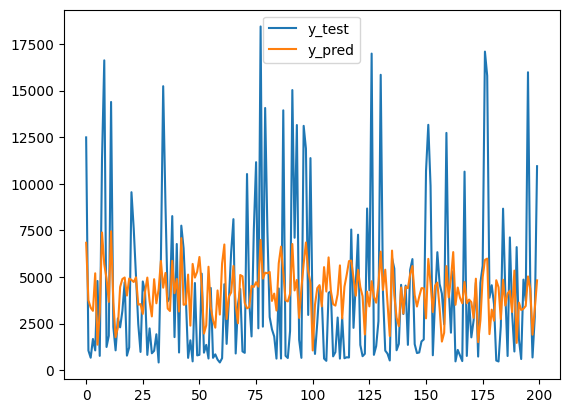

In [70]:

#TODO ELIGE UNA BUENA GRÁFICA, SI TIENES POCOS DATOS, LA PRIMERA, SI TIENES MUCHOS, LA SEGUNDA OPCION

#OPción 1: pocos datos
df_results.plot()

# # Crear un gráfico de densidad para los valores reales y predichos
# sns.lineplot(df_results['y_test'], label='y_test')
# sns.lineplot(df_results['y_pred'], label='y_pred')
# plt.legend()
# plt.show()

In [71]:
df_results['error'] = df_results['y_test'] - df_results['y_pred']
df_results.head()

,y_test,y_pred,error
0,12493.0,6838.966309,5654.033691
1,1060.0,3755.779053,-2695.779053
2,673.0,3358.780762,-2685.780762
3,1678.0,3188.188477,-1510.188477
4,1066.0,5201.700195,-4135.700195
